In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats as st
from sklearn.preprocessing import scale, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import linear_model as lm
from sklearn.metrics import mean_squared_error, r2_score
from tabulate import tabulate
import statsmodels.api as sm

In [2]:
source_data_path = "./../tcs_stock.csv"
row_df = pd.read_csv(source_data_path)
row_df["Deliverble(%)"] = row_df['%Deliverble']

In [3]:
feature_cols = ['Open', 'Low', 'Last', 'Close', 'Trades', 'Deliverble(%)']
target_col = 'High'

df = row_df[feature_cols + [target_col]]
df.head()

,Open,Low,Last,Close,Trades,Deliverble(%),High
0,2567.0,2541.00,2550.00,2545.55,8002,0.2883,2567.00
1,2551.0,2550.60,2588.40,2579.45,27585,0.6683,2590.95
2,2581.0,2524.65,2538.10,2540.25,43234,0.5207,2599.90
3,2529.1,2440.00,2450.05,2446.60,84503,0.5894,2529.10
4,2470.0,2407.45,2426.90,2417.70,101741,0.6724,2479.15


In [4]:
features = df[feature_cols]
target = df[target_col]

## Step 1. You need to make a non-parametric estimation of PDF in form of histogram and using kernel density function for MRV (or probability law in case of discrete MRV)

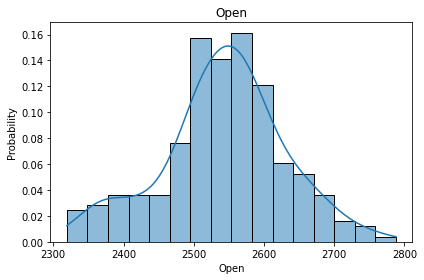

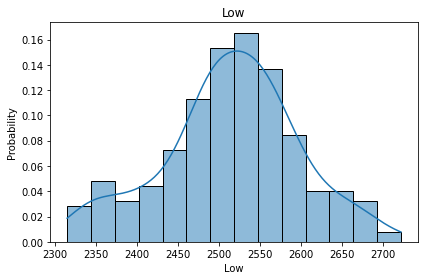

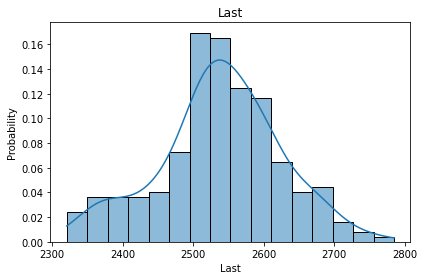

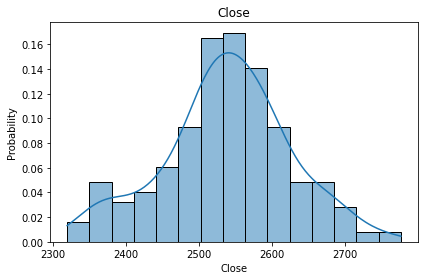

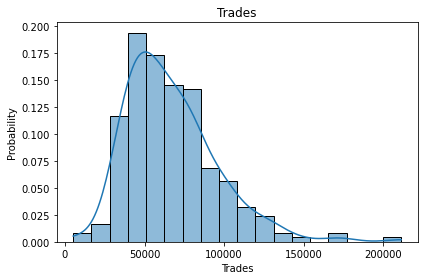

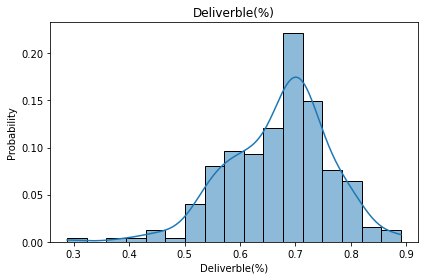

In [5]:
for col in feature_cols:
    fig, ax = plt.subplots(tight_layout=True)
    sb.histplot(df[col], ax=ax, kde=True, stat="probability")
    plt.title(col)
    plt.show()

## Step 2. You need to make an estimation of multivariate mathematical expectation and variance.

In [6]:
df.mean()

Open              2542.172782
Low               2514.408468
Last              2538.039718
Close             2537.717944
Trades           66873.608871
Deliverble(%)        0.670336
High              2563.580444
dtype: float64

In [7]:
df.var()

Open             7.674758e+03
Low              6.881163e+03
Last             7.542802e+03
Close            7.579063e+03
Trades           8.342223e+08
Deliverble(%)    8.275145e-03
High             8.208064e+03
dtype: float64

## Step 3. You need to make a non-parametric estimation of conditional distributions, mathematical expectations and variances.

In [8]:
condition_more = df['Trades'] >= 66000
condition_less = df['Trades'] < 66000

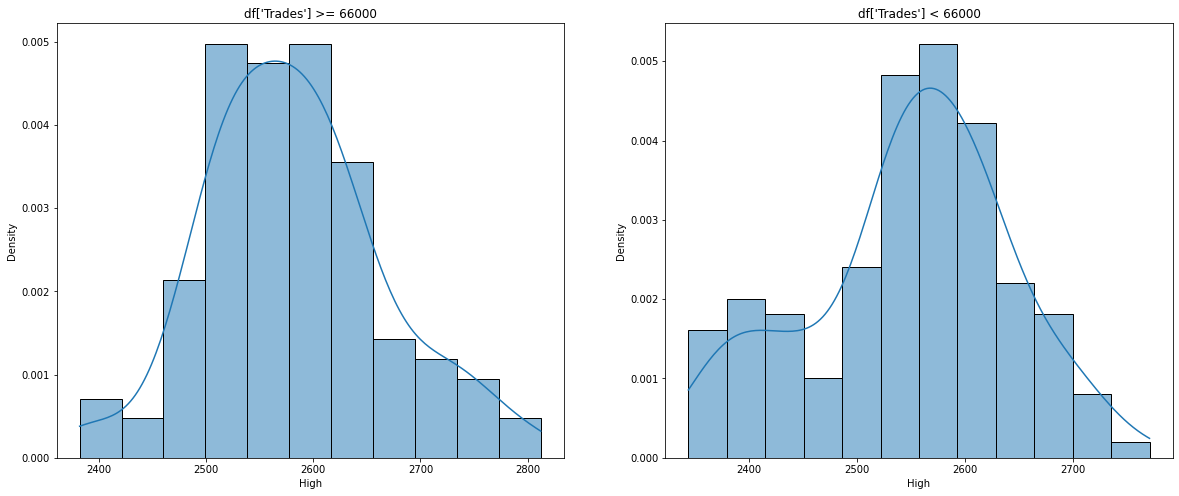

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

sb.histplot(df[condition_more]['High'], ax=ax1, kde=True, stat="density")
ax1.set_title("df['Trades'] >= 66000")

sb.histplot(df[condition_less]['High'], ax=ax2, kde=True, stat="density")
ax2.set_title("df['Trades'] < 66000")

plt.show()

In [10]:
df[condition_more].mean()

Open              2558.012500
Low               2523.619444
Last              2550.018056
Close             2549.429630
Trades           92309.546296
Deliverble(%)        0.691087
High              2582.467130
dtype: float64

In [11]:
df[condition_more].var()

Open             6.191144e+03
Low              5.887515e+03
Last             6.700395e+03
Close            6.871748e+03
Trades           5.982571e+08
Deliverble(%)    6.254171e-03
High             7.031163e+03
dtype: float64

## Step 4. You need to make an estimation of pair correlation coefficients, confidence intervals for them and significance levels.

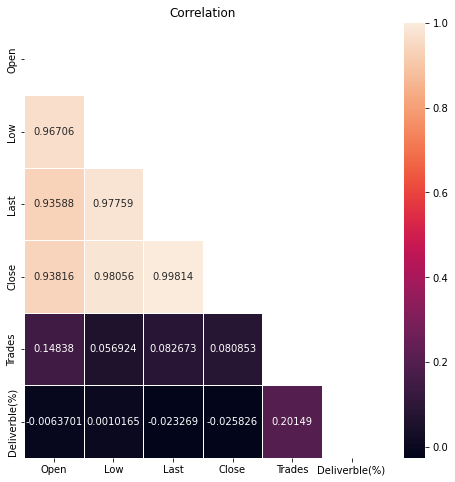

In [12]:
fig, ax = plt.subplots(figsize=(8,8))

corr = features.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sb.heatmap(corr, mask=mask, annot=True, ax=ax, vmax=1, fmt='.5g', linewidths=.5)

plt.title('Correlation')
plt.show()

In [13]:
def _estimate_correlation(x, y):
    return st.pearsonr(x, y)
    
def _estimate_confidence_intervals(cor, x, y, alpha = 0.05):
    coeff = np.arctanh(cor)

    std = 1/np.sqrt(x.size-3)
    z = st.norm.ppf(1-alpha/2)
    return coeff-z*std, coeff+z*std

In [14]:
tab = [["Pair", "Correlation coeff", "Low border of conf interval", "High border of conf interval"]]
for i, x_col_name in enumerate(feature_cols):
    j = i + 1
    
    if j >= len(feature_cols):
        break
        
    for k in range(j, len(feature_cols)):
        y_col_name = feature_cols[k]
        x = df[x_col_name]
        y = df[y_col_name]
        
        cor, p = _estimate_correlation(x, y)
        
        low, high = _estimate_confidence_intervals(cor, x, y)
        tab.append([f'{x_col_name} - {y_col_name}',cor,low,high])
print(tabulate(tab, headers="firstrow", tablefmt="grid"))

+------------------------+---------------------+-------------------------------+--------------------------------+
| Pair                   |   Correlation coeff |   Low border of conf interval |   High border of conf interval |
+========================+=====================+===============================+================================+
| Open - Low             |          0.967063   |                     1.91963   |                      2.17006   |
+------------------------+---------------------+-------------------------------+--------------------------------+
| Open - Last            |          0.935876   |                     1.57853   |                      1.82896   |
+------------------------+---------------------+-------------------------------+--------------------------------+
| Open - Close           |          0.938159   |                     1.59724   |                      1.84768   |
+------------------------+---------------------+-------------------------------+--------

## Step 5. Choose a task formulation for regression. Estimate multivariate correlation (target -predictors).

Predict values of 'High' feature

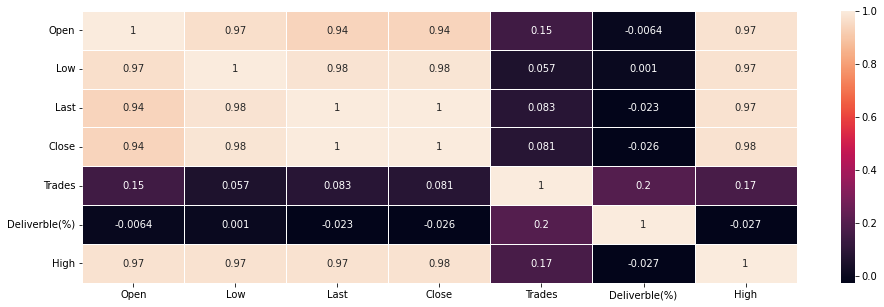

In [15]:
plt.figure(figsize=(16, 5))
sb.heatmap(df.corr(method='pearson'), annot=True, linewidths=.5)
plt.show()

Use PCA method and see how many variables we need to take for regression.

In [16]:
#Standardize a dataset
std_df = scale(df)
std_df = pd.DataFrame(std_df, index=df.index, columns=df.columns)

In [17]:
std_df.head()

,Open,Low,Last,Close,Trades,Deliverble(%),High
0,0.283970,0.321211,0.137992,0.090146,-2.042407,-4.208179,0.037820
1,0.100965,0.437173,0.581031,0.480330,-1.363023,-0.022430,0.302709
2,0.444101,0.123712,0.000696,0.029144,-0.820119,-1.648263,0.401696
3,-0.149525,-0.898812,-1.015180,-1.048754,0.611609,-0.891524,-0.381355
4,-0.825503,-1.291997,-1.282272,-1.381388,1.209639,0.022732,-0.933805


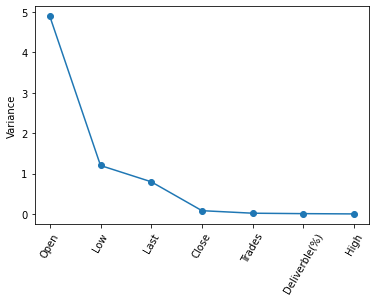

In [18]:
pca = PCA().fit(std_df)
y = np.std(pca.transform(std_df), axis=0)**2
x = np.arange(len(y)) + 1
plt.plot(x, y, "o-")
plt.xticks(x, [f"Comp.{i}" for df.columns, rotation=60)
plt.ylabel("Variance")
plt.show()

I think that 3 features is ok. Let's use Open, Close, Low

## Step 6. Build regression model and make an analysis of multicollinearity and regularization (if needed).

In [33]:
train, test = train_test_split(df[['High', 'Open', 'Close', 'Low']].copy())

train_feature = train[['Open', 'Close', 'Low']]
test_feature = test[['Open', 'Close', 'Low']]

train_target = train['High']
test_target = test['High']

In [20]:
tab = [["Type", "MSE", "R2", "Coeff"]]

regression = lm.LinearRegression()
regression.fit(train_feature, train_target)
predicted = regression.predict(test_feature)
tab.append(["Least Squares model", str(mean_squared_error(test_target, predicted)), str(r2_score(test_target, predicted)), str(regression.coef_)])

regression = lm.Lasso(alpha=0.0001, random_state=5)
regression.fit(train_feature, train_target)
predicted = regression.predict(test_feature)
tab.append(["Lasso model", str(mean_squared_error(test_target, predicted)), str(r2_score(test_target, predicted)), str(regression.coef_)])

regression = lm.Ridge(random_state=1)
regression.fit(train_feature, train_target)
predicted = regression.predict(test_feature)
tab.append(["Ridge model", str(mean_squared_error(test_target, predicted)), str(r2_score(test_target, predicted)), str(regression.coef_)])

print(tabulate(tab, headers="firstrow", tablefmt="grid"))

+---------------------+---------+----------+---------------------------------------+
| Type                |     MSE |       R2 | Coeff                                 |
+=====================+=========+==========+=======================================+
| Least Squares model | 154.324 | 0.973688 | [ 0.61183695  0.73816119 -0.32282928] |
+---------------------+---------+----------+---------------------------------------+
| Lasso model         | 154.324 | 0.973688 | [ 0.61183662  0.73816111 -0.32282885] |
+---------------------+---------+----------+---------------------------------------+
| Ridge model         | 154.325 | 0.973688 | [ 0.61182267  0.73813709 -0.3227891 ] |
+---------------------+---------+----------+---------------------------------------+


## Step 7. Analyze the quality of regression model (distribution of residuals, determination coefficient).

R^2 score can be find at the end of Step 6

In [21]:
X = df[['Open', 'Close', 'Low']]
Y = df['High']

In [22]:
def _draw_qq_plot(predicted, predicted_all):
    percs = np.linspace(0, 100, 21)
    qn_first = np.percentile(predicted, percs)
    qn_second = np.percentile(predicted_all, percs)

    plt.figure(figsize=(8,8))

    min_qn = np.min([qn_first.min(), qn_second.min()])
    max_qn = np.min([qn_first.max(), qn_second.max()])
    x = np.linspace(min_qn, max_qn)

    plt.plot(qn_first, qn_second, ls="", marker="o", markersize=6)
    plt.plot(x,x,color="k", ls="--")
    plt.show

R^2 score = 0.9697279864152346


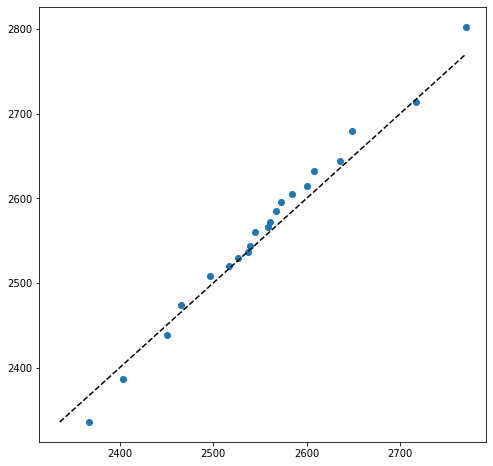

In [34]:
regression = lm.LinearRegression()
regression.fit(train_feature, train_target)
predicted = regression.predict(test_feature)

print('R^2 score =', r2_score(test_target, predicted))

predicted_all = regression.predict(X)
_draw_qq_plot(predicted, predicted_all)

R^2 show a good quality of our model as a qqplot

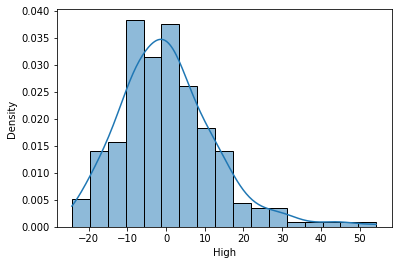

In [35]:
residuals = Y - regression.predict(X)
ax = sb.histplot(residuals, kde = 'True', stat="density")

In [25]:
st.kstest(residuals, 'norm', args=(residuals.mean(), residuals.var()))

KstestResult(statistic=0.4353543408175741, pvalue=2.886743745829084e-43)

Residuals are not distributed normally.

In [26]:
mod = sm.OLS(train_target, train_feature)
res = mod.fit()
print(res.conf_int(0.01))

              0         1
Open   0.510829  0.731068
Close  0.617991  0.902066
Low   -0.573751 -0.176412


In [37]:
residuals.describe()

count    248.000000
mean       0.380230
std       12.471677
min      -24.312439
25%       -8.113857
50%       -0.971024
75%        6.655066
max       54.325712
Name: High, dtype: float64